# Building a Spotify Recommendation Engine for Music Labels
## Recommendation and Clustering
### Flatiron School Data Science Program Phase 4 Project<br>Justin Williams & Khyatee Desai

In [5]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from zipfile import ZipFile 
from sklearn import set_config
set_config(print_changed_only=False, display=None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
import sys
import statistics

# Spotify API Data Collection
The following process is used to collect song attributes for a user's given playlist from the Spotify API

In [6]:
# create a sample playlist
playlist = ['Polly - Moses Sumney', 'Goodbye - Porches','rangerover - Porches','Tal Uno - Barrie',
               "Angel's Song - Arlo Parks",'Randy - Big Thief', 'Butterfly - Adrianne Lenker',
               'All of Me Wants All of You - Sufjan Stevens','Cola - Arlo Parks']

### Get spotify id's for each song

In [7]:
# save my credentials
os.environ["SPOTIPY_CLIENT_ID"] = "a8561b2ef375442f8f89527b255f4c78"
os.environ["SPOTIPY_CLIENT_SECRET"] = "566a59fd72764b9580f8767c5bc0ca7f"

spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials())

# save song id's, release dates, and song popularity in lists
song_ids = []
release_dates = []
popularities = []
for song in playlist:
    try:
        results = spotify.search(q=song, type='track')
        song_ids.append(results['tracks']['items'][0]['id'])
        release_dates.append(results['tracks']['items'][0]['album']['release_date'])
        popularities.append(results['tracks']['items'][0]['popularity'])
    except:
        print("Couldn't find:", song,'\n')

### Retrieve Song attributes for each song

In [8]:
# use the song id's gathered above to get audio attributes for each song
attributes = spotify.audio_features(tracks=song_ids)
attributes[0]

{'danceability': 0.389,
 'energy': 0.258,
 'key': 10,
 'loudness': -11.534,
 'mode': 1,
 'speechiness': 0.0315,
 'acousticness': 0.927,
 'instrumentalness': 5.2e-05,
 'liveness': 0.0906,
 'valence': 0.195,
 'tempo': 137.831,
 'type': 'audio_features',
 'id': '6LQOd5wz3RmBFFZxdhSfLT',
 'uri': 'spotify:track:6LQOd5wz3RmBFFZxdhSfLT',
 'track_href': 'https://api.spotify.com/v1/tracks/6LQOd5wz3RmBFFZxdhSfLT',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6LQOd5wz3RmBFFZxdhSfLT',
 'duration_ms': 218413,
 'time_signature': 4}

In [9]:
# combine the song popularity and release dates with the rest of the attributes
for i in range(len(attributes)):
    attributes[i]['track/artist'] = playlist[i]
    attributes[i]['popularity'] = popularities[i]
    attributes[i]['release_date'] = release_dates[i]
    
# create a dataframe from all the attributes
playlist_df = pd.DataFrame(attributes)

# Spotify Data Cleaning

### Create Decade Column

In [10]:
# drop unecessary features 
playlist_df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature'], axis=1, inplace=True)

# set release date as datetime
playlist_df['release_date'] = pd.to_datetime(playlist_df['release_date'])

# make year column datetime
playlist_df['year'] = playlist_df['release_date'].dt.year

# create decade column
playlist_df['decade'] = playlist_df['year'].apply(lambda x: str(x)[:3]+'0s')

### Map Keys/Modes to make more interpretable

In [11]:
# change keys/mode to letter/maj/min representations
keys = {0:'C', 1:'Db',2:'D',3:'Eb',4:'E',5:'F',6:'F#',7:'G',8:'Ab',9:'A',10:'Bb',11:'B'}
modes = {0:'Minor',1:'Major'}

# create new column in df
playlist_df['letter_keys'] = playlist_df['key'].map(keys)
playlist_df['modes'] = playlist_df['mode'].map(modes)

round(playlist_df['letter_keys'].value_counts(normalize=True)*100, 2)

B     33.33
E     22.22
D     11.11
C     11.11
Bb    11.11
G     11.11
Name: letter_keys, dtype: float64

In [12]:
# create a column that concatonates key with mode
playlist_df['key_mode'] = playlist_df['letter_keys'] + " " + playlist_df['modes']

### Impute Outliers

In [13]:
# Bring outliers down/up to 5 standard deviations from the mean
for feat in playlist_df.columns:
    try:
        abv_5_std = playlist_df[feat].mean()+ 5* playlist_df[feat].std()
        below_5_std = playlist_df[feat].mean()- 5* playlist_df[feat].std()
        conditions = [playlist_df[feat]>abv_5_std, playlist_df[feat]<below_5_std]
        choices = [abv_5_std, below_5_std]
        df[feat] = np.select(conditions, choices, playlist_df[feat])
    except:
        pass

### Standardize

In [14]:
# Scale features down to 0-1
playlist_df['scaled_speech'] = (playlist_df['speechiness'] - min(playlist_df['speechiness'])) / (max(playlist_df['speechiness']) - min(playlist_df['speechiness']))
playlist_df['scaled_duration'] = (playlist_df['duration_ms'] - min(playlist_df['duration_ms'])) / (max(playlist_df['duration_ms']) - min(playlist_df['duration_ms']))
playlist_df['scaled_loudness'] = (playlist_df['loudness'] - min(playlist_df['loudness'])) / (max(playlist_df['loudness']) - min(playlist_df['loudness']))
playlist_df['scaled_tempo'] = (playlist_df['tempo'] - min(playlist_df['tempo'])) / (max(playlist_df['tempo']) - min(playlist_df['tempo']))
playlist_df['scaled_pop'] = (playlist_df['popularity'] - min(playlist_df['popularity'])) / (max(playlist_df['popularity']) - min(playlist_df['popularity']))


### Create Dummy Variables

In [15]:
# all the dummies from the big dataset
all_dummies = ['A Major', 'A Minor',
       'Ab Major', 'Ab Minor', 'B Major', 'B Minor', 'Bb Major', 'Bb Minor',
       'C Major', 'C Minor', 'D Major', 'D Minor', 'Db Major', 'Db Minor',
       'E Major', 'E Minor', 'Eb Major', 'Eb Minor', 'F Major', 'F Minor',
       'F# Major', 'F# Minor', 'G Major', 'G Minor', '1920s', '1930s', '1940s',
       '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

# make dummies for key/mode and decades
key_dummies = pd.get_dummies(playlist_df['key_mode'])
decade_dummies = pd.get_dummies(playlist_df['decade'])
dummies = pd.concat([ key_dummies, decade_dummies], axis=1)

# check which dummies weren't created - we need to add these in as zeros so the dataframes have the same shape
playlist_df = pd.concat([playlist_df, key_dummies, decade_dummies], axis=1)
zeroes = list(set(all_dummies) - set(dummies.columns))

# add those dummies in as zeroes
for col in zeroes:
    playlist_df[col] = 0

# drop first column for dummies
playlist_df.drop(['A Major', '1920s'],axis=1, inplace=True)

In [16]:
playlist_df.shape

(9, 58)

# Building the Recommender
### Import Record Labels dataset

In [17]:
labels_df = pd.read_csv('data/cleaned_data_labels.csv',index_col=[0])

# drop unnecesary features
labels_df.drop(['key_mode', 'decade', 'modes', 'letter_keys',  'year', 
         'release_date', 'mode', 'loudness', 'key', 'id', 'explicit', 
         'tempo', 'duration_ms', 'speechiness', 'popularity' ], axis=1, inplace=True)

In [18]:
# dataframe of all Dead Oceans songs as a test sample
ocean_df = labels_df[labels_df.label == 'Dead Oceans']
ocean_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,name,valence,scaled_speech,scaled_duration,scaled_loudness,scaled_tempo,scaled_pop,A Minor,Ab Major,Ab Minor,B Major,B Minor,Bb Major,Bb Minor,C Major,C Minor,D Major,D Minor,Db Major,Db Minor,E Major,E Minor,Eb Major,Eb Minor,F Major,F Minor,F# Major,F# Minor,G Major,G Minor,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s,artist,label
3919,0.162000,0.181,0.486,0.2030,0.1110,Machine Gun,0.0545,0.152872,0.048459,0.716686,0.633260,0.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,Slowdive,Dead Oceans
3920,0.098700,0.172,0.745,0.0073,0.2350,40 Days,0.4910,0.153282,0.035013,0.774223,0.757644,0.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Slowdive,Dead Oceans
3921,0.195000,0.129,0.647,0.2920,0.1040,Machine Gun,0.0393,0.156970,0.048824,0.792687,0.633165,0.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Slowdive,Dead Oceans
3922,0.001370,0.431,0.482,0.4410,0.2380,Ballad Of Sister Sue,0.1230,0.126232,0.049432,0.816804,0.524579,0.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,Slowdive,Dead Oceans
3923,0.000057,0.227,0.480,0.8350,0.0477,Catch The Breeze,0.1880,0.159020,0.047115,0.841203,0.379780,0.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Slowdive,Dead Oceans


### Cosine Similarities
Calculate cosine similarities between user playlist and all Dead Oceans songs

In [19]:
# turn both dataframes into numpy arrays
playlist_array = np.array(playlist_df.drop(['decade','duration_ms','key','key_mode','letter_keys',
                     'loudness','mode','modes','popularity','release_date','speechiness',
                         'tempo','track/artist','year'], axis=1))

label_array = np.array(ocean_df.drop(['artist','name','label'], axis=1))

In [20]:
# turn both arrays into sparse matrices
playlist_sparse = sparse.csr_matrix(playlist_array)
label_sparse = sparse.csr_matrix(label_array)

# get cosine similarities between user playlist and record label
cosim = cosine_similarity(playlist_sparse, label_sparse,dense_output=True)
print(cosim[0])


[0.41048198 0.46508308 0.50690708 0.38347746 0.38167026 0.47863051
 0.389911   0.39059759 0.35573562 0.36883794 0.27732504 0.39653992
 0.40443136 0.37710166 0.40054964 0.30535826 0.43224922 0.35005341
 0.3650677  0.39990222 0.35987119 0.35287898 0.4347205  0.40957185
 0.4273254  0.6799827  0.39989644 0.38722497 0.46576319 0.66389508
 0.44183993 0.64154536 0.43386476 0.62117831 0.4472665  0.38027091
 0.36413054 0.42236729 0.62774839 0.42997248 0.43353232 0.43207587
 0.47329969 0.40911743 0.39949446 0.38289718 0.3508459  0.35654525
 0.36190396 0.33774586 0.36539917 0.40163796 0.43061679 0.3559152
 0.35101306 0.44434106 0.39586729 0.46860207 0.45046191 0.60696489
 0.44746828 0.39339233 0.43816977 0.64842426 0.4429689  0.4227782
 0.41794975 0.38316499 0.3656166  0.46221482 0.6138289  0.38686906
 0.64005204 0.32723175 0.6693392  0.42299694 0.6051339  0.40815275
 0.41238729 0.61936899 0.41138316]


In [21]:
playlist_array.shape

(9, 44)

In [22]:
label_array.shape

(81, 44)

In [23]:
ocean_df.shape

(81, 47)

In [24]:
playlist_df.shape

(9, 58)

### Make Recommendations
Sort by highest similarities and map the output to song names/artists

In [25]:
for i in range(len(cosim)):
    print('Dead Oceans songs similar to', playlist_df.iloc[i]['track/artist'],':\n' )
    print(sorted(list(zip(cosim[i],ocean_df['name'], ocean_df['artist'])), reverse=True)[:2])
    print('================================================================================================================')

Dead Oceans songs similar to Polly - Moses Sumney :

[(0.6799826957661531, 'A Perfect Sonnet', 'Bright Eyes'), (0.6693392046451008, 'Nobody', 'Mitski')]
Dead Oceans songs similar to Goodbye - Porches :

[(0.7235321945507469, 'Day Glo', 'Brazos'), (0.6911031673391842, 'Kyoto', 'Phoebe Bridgers')]
Dead Oceans songs similar to rangerover - Porches :

[(0.7543136314811328, 'At The Bottom Of Everything', 'Bright Eyes'), (0.748801127319026, 'June On The West Coast', 'Bright Eyes')]
Dead Oceans songs similar to Tal Uno - Barrie :

[(0.6550584864922804, 'Evan Finds the Third Room', 'Khruangbin'), (0.6489500292716106, 'Sing', 'Slowdive')]
Dead Oceans songs similar to Angel's Song - Arlo Parks :

[(0.6289516252365083, 'Sing', 'Slowdive'), (0.6170170076895379, 'Sing', 'Slowdive')]
Dead Oceans songs similar to Randy - Big Thief :

[(0.5105669076285985, 'Evan Finds the Third Room', 'Khruangbin'), (0.5105604536560789, 'Dagger', 'Slowdive')]
Dead Oceans songs similar to Butterfly - Adrianne Lenker :


# Optimization
Put it all in functions, and generalize to any record label. If music label is not provided, the function will return songs from the label that is most similar to user's given playlist.

### Function: Collect Data from Spotify API

In [26]:
def spotifyAPI(playlist):
    '''input: user playlist of songs (list) in format [song name - artist, song name - artist, etc]
    Case insensitive.
        output: Pandas dataframe of raw song attributes collected from Spotify'''

    spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials())

    # save song id's, release dates, and song popularity in lists
    song_ids = []
    release_dates = []
    popularities = []
    for song in playlist:
        try:
            results = spotify.search(q=song, type='track')
            song_ids.append(results['tracks']['items'][0]['id'])
            release_dates.append(results['tracks']['items'][0]['album']['release_date'])
            popularities.append(results['tracks']['items'][0]['popularity'])
        except:
            print("Couldn't find:", song, '\n')
            pass

        
    # use the song id's gathered above to get audio attributes for each song
    attributes = spotify.audio_features(tracks=song_ids)
    
    # combine the song popularity and release dates with the rest of the attributes
    for i in range(len(attributes)):
        attributes[i]['track/artist'] = playlist[i]
        attributes[i]['popularity'] = popularities[i]
        attributes[i]['release_date'] = release_dates[i]

    # create a dataframe from all the attributes
    playlist_df = pd.DataFrame(attributes)
    return playlist_df

### Function: Clean and Prep Raw Dataframe

In [27]:
def clean(playlist_df):
    '''input: Pandas dataframe of raw spotify song attributes collected from Spotify API
        output: Cleaned dataframe, with dummy variables and fewer unnecessary columns'''
    
    
    # drop unecessary features 
    playlist_df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature'], axis=1, inplace=True)

    # set release date as datetime
    playlist_df['release_date'] = pd.to_datetime(playlist_df['release_date'])

    # make year column datetime
    playlist_df['year'] = playlist_df['release_date'].dt.year

    # create decade column
    playlist_df['decade'] = playlist_df['year'].apply(lambda x: str(x)[:3]+'0s')
    
    # change keys/mode to letter/maj/min representations
    keys = {0:'C', 1:'Db',2:'D',3:'Eb',4:'E',5:'F',6:'F#',7:'G',8:'Ab',9:'A',10:'Bb',11:'B'}
    modes = {0:'Minor',1:'Major'}

    # create new column in df
    playlist_df['letter_keys'] = playlist_df['key'].map(keys)
    playlist_df['modes'] = playlist_df['mode'].map(modes)

    # create a column that concatonates key with mode
    playlist_df['key_mode'] = playlist_df['letter_keys'] + " " + playlist_df['modes']
    
    # Bring outliers down/up to 5 standard deviations from the mean
    for feat in playlist_df.columns:
        try:
            abv_5_std = playlist_df[feat].mean()+ 5* playlist_df[feat].std()
            below_5_std = playlist_df[feat].mean()- 5* playlist_df[feat].std()
            conditions = [playlist_df[feat]>abv_5_std, playlist_df[feat]<below_5_std]
            choices = [abv_5_std, below_5_std]
            df[feat] = np.select(conditions, choices, playlist_df[feat])
        except:
            pass
        
    # Scale features down to 0-1
    playlist_df['scaled_speech'] = (playlist_df['speechiness'] - min(playlist_df['speechiness'])) / (max(playlist_df['speechiness']) - min(playlist_df['speechiness']))
    playlist_df['scaled_duration'] = (playlist_df['duration_ms'] - min(playlist_df['duration_ms'])) / (max(playlist_df['duration_ms']) - min(playlist_df['duration_ms']))
    playlist_df['scaled_loudness'] = (playlist_df['loudness'] - min(playlist_df['loudness'])) / (max(playlist_df['loudness']) - min(playlist_df['loudness']))
    playlist_df['scaled_tempo'] = (playlist_df['tempo'] - min(playlist_df['tempo'])) / (max(playlist_df['tempo']) - min(playlist_df['tempo']))
    playlist_df['scaled_pop'] = (playlist_df['popularity'] - min(playlist_df['popularity'])) / (max(playlist_df['popularity']) - min(playlist_df['popularity']))

    # all the dummies from the big dataset
    all_dummies = ['A Major', 'A Minor',
           'Ab Major', 'Ab Minor', 'B Major', 'B Minor', 'Bb Major', 'Bb Minor',
           'C Major', 'C Minor', 'D Major', 'D Minor', 'Db Major', 'Db Minor',
           'E Major', 'E Minor', 'Eb Major', 'Eb Minor', 'F Major', 'F Minor',
           'F# Major', 'F# Minor', 'G Major', 'G Minor', '1920s', '1930s', '1940s',
           '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

    # make dummies for key/mode and decades
    key_dummies = pd.get_dummies(playlist_df['key_mode'])
    decade_dummies = pd.get_dummies(playlist_df['decade'])
    dummies = pd.concat([ key_dummies, decade_dummies], axis=1)

    # check which dummies weren't created - we need to add these in as zeros so the dataframes have the same shape
    playlist_df = pd.concat([playlist_df, key_dummies, decade_dummies], axis=1)
    zeroes = list(set(all_dummies) - set(dummies.columns))

    # add those dummies in as zeroes
    for col in zeroes:
        playlist_df[col] = 0

    # drop first column for dummies
    playlist_df.drop(['A Major', '1920s'],axis=1, inplace=True)
    return(playlist_df)

### Function: Make Recommendations

In [28]:
def get_recs(playlist, record_label=None):
    '''input 1: user playlist of songs (list) in format 
            [song name - artist, song name - artist, etc.] Case insensitive.
    input 2: (optional) record label name (string.) If record label not provided,
        function will use label that is most similar to user's given playlist.
    output: Playlist (text output) including Record label name, and recommended songs
        '''
    
    # collect and clean spotify data based on user's playlist
    raw_playlist_df = spotifyAPI(playlist)
    clean_playlist_df = clean(raw_playlist_df)

    # import record labels dataset
    labels_df = pd.read_csv('data/cleaned_data_labels.csv',index_col=[0])

    # drop unnecesary features
    labels_df.drop(['key_mode', 'decade', 'modes', 'letter_keys',  'year', 
             'release_date', 'mode', 'loudness', 'key', 'id', 'explicit', 
             'tempo', 'duration_ms', 'speechiness', 'popularity' ], axis=1, inplace=True)
    
    label_pool=[]
    if not record_label:
        label_pool = labels_df.label.unique()
    else:
        label_pool.append(record_label)    
    
    label_dict={}
    for label in label_pool:
        # dataframe of all specified label's songs
        label_df = labels_df[labels_df.label == label]

        # turn both dataframes into numpy arrays
        playlist_array = np.array(clean_playlist_df.drop(['decade','duration_ms','key','key_mode','letter_keys',
                             'loudness','mode','modes','popularity','release_date','speechiness',
                                 'tempo','track/artist','year'], axis=1))
        label_array = np.array(label_df.drop(['artist','name','label'], axis=1))

        # turn both arrays into sparse matrices
        playlist_sparse = sparse.csr_matrix(playlist_array)
        label_sparse = sparse.csr_matrix(label_array)

        # get cosine similarities between user playlist and record label
        # cosim contains three arrays, one for each song from user playlist
        label_dict[label] =cosine_similarity(playlist_sparse, label_sparse,dense_output=True) 

    # flatten each song cosim per label and put in dictionary
    mean_cosims ={}
    for key in label_dict:
        flattened_cosim = [item for items in label_dict[key] for item in items]
        mean_cosims[statistics.mean(flattened_cosim)]=key
    
    # find best record label by getting one with largest avg cosine sim
    best_label = (mean_cosims[max(mean_cosims)])
    label_df = labels_df[labels_df.label == best_label]
    song_cosims = label_dict[best_label]
    
    # go through best label and get track name and artist with highest cosim
    recs=[]
    for song_cosim in song_cosims:
        two_recs = sorted(list(zip(song_cosim,label_df['name'], label_df['artist'])), reverse=True)[:2]
        recs.append((two_recs[0][1]+', by '+two_recs[0][2]))
        recs.append((two_recs[1][1]+', by '+two_recs[1][2]))

    # output the results, removing duplicates
    if not record_label:
        print("We think you're gonna like",best_label,'records!')
    print(best_label,'songs similar to your playlist:\n')
    for song in list(set(recs)):
        print(song)

# Model Evaluation
Using empirical evaluation methods to determine quality of recommendations

### Khyatee's Playlist
Using Fat Possum Records

In [29]:
khyatees_playlist = ['Polly - Moses Sumney', 'Goodbye - Porches','rangerover - Porches','Tal Uno - Barrie',
               "Angel's Song - Arlo Parks",'Randy - Big Thief', 'Butterfly - Adrianne Lenker',
               'All of Me Wants All of You - Sufjan Stevens','Cola - Arlo Parks']

get_recs(khyatees_playlist, 'Fat Possum')


Fat Possum songs similar to your playlist:

No Bones, by Dinosaur Jr.
Clay Pigeons, by Blaze Foley
Get Me, by Dinosaur Jr.
Sleepwalking (Couples Only Dance Prom Night), by Modest Mouse
Be Here to Love Me, by Townes Van Zandt
I'm Not the One, by The Black Keys
I Put My Trust In You, by John Lee Hooker
Run On, by John Lee Hooker
10 A.M. Automatic, by The Black Keys
A New Leaf, by John Lee Hooker
Parting of the Sensory, by Modest Mouse
Debora, by T. Rex
Mr. Mudd & Mr. Gold - Live, by Townes Van Zandt
Girl - Remastered, by T. Rex
Our Swords, by Band of Horses
Strange Times, by The Black Keys


### Justin's Playlist

### XL Records Playlist
No record label provided, to make sure XL songs are recommended back

In [ ]:
XL_playlist = ["Shabop Shalom - Devendra Banhart", "jasmine - demo - Jai Paul",
               "I Think I Smell A Rat - The White Stripes", "Hometown Glory - Adele",
                "Close To You - The Avalanches"]
get_recs(XL_playlist)

### Fangfang's Playlist

In [30]:
fangfang_playlist = ["lost in yesterday - tame impala", "maria también - khruangbin",
                    "girl - the internet"]
get_recs(fangfang_playlist)

We think you're gonna like Third Man records!
Third Man songs similar to your playlist:

On a Monday (I'm Almost Done), by Lead Belly
Hope, by Jack Johnson
Goodbye, Little Darlin', Goodbye, by Johnny Cash
Situations, by Jack Johnson
Burning Hell, by John Lee Hooker
Smokestack Lightnin', by Howlin' Wolf


### Nick's Playlist

# Clustering

In [231]:
from sklearn.cluster import KMeans

In [232]:
playlist_df2 = playlist_df.drop(['decade','duration_ms','key','key_mode','letter_keys',
                     'loudness','mode','modes','popularity','release_date','speechiness',
                         'tempo','track/artist','year'], axis=1)

label_df2 = ocean_df.drop(['artist','name','label'], axis=1)

In [233]:
# concat playlist and label array

main_df = pd.concat([playlist_df2, label_df2], axis=0)

In [234]:
pd.set_option('display.max_rows', None)

In [235]:
main_df.head()

,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s,A Minor,Ab Major,Ab Minor,B Major,B Minor,Bb Major,Bb Minor,C Major,C Minor,D Major,D Minor,Db Major,Db Minor,E Major,E Minor,Eb Major,Eb Minor,F Major,F Minor,F# Major,F# Minor,G Major,G Minor,acousticness,danceability,energy,instrumentalness,liveness,scaled_duration,scaled_loudness,scaled_pop,scaled_speech,scaled_tempo,valence
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9270,0.389,0.258,0.000052,0.0906,0.628629,0.426757,0.46875,0.026611,0.839219,0.195
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.2900,0.452,0.527,0.002140,0.1020,0.236312,0.710087,0.37500,0.054622,0.532766,0.363
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0584,0.634,0.654,0.000000,0.1990,0.000000,1.000000,0.50000,0.134921,1.000000,0.782
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0606,0.533,0.623,0.897000,0.2950,1.000000,0.677545,0.56250,0.000000,0.464719,0.421
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.8940,0.693,0.195,0.032500,0.1260,0.467736,0.079640,0.75000,0.087768,0.555273,0.315


In [236]:
main_array = np.array(main_df)

In [244]:
main_array[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.27000000e-01, 3.89000000e-01, 2.58000000e-01,
       5.20000000e-05, 9.06000000e-02, 6.28629192e-01, 4.26756907e-01,
       4.68750000e-01, 2.66106443e-02, 8.39219168e-01, 1.95000000e-01])

In [238]:
label_array[0]

array([0.162     , 0.181     , 0.486     , 0.203     , 0.111     ,
       0.0545    , 0.15287199, 0.04845869, 0.71668624, 0.63325973,
       0.4       , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        ])

In [245]:
# instantiate kmeans class and set n_clusters
k_means = KMeans(random_state=1) # default n_clusters = 8

# fit to data
# k_means.fit(label_array)

# predict which clusters each song belongs too
predicted_clusters = k_means.fit_predict(main_array)
predicted_clusters # each instance was assigned to one of the clusters

array([6, 1, 6, 1, 1, 4, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 0, 0,
       7, 7, 7, 7, 0, 0, 0, 0, 7, 2, 2, 2, 4, 2, 2, 2, 5, 2, 5, 0, 4, 2,
       2, 2, 2, 5, 2, 3, 3, 3, 2, 3, 3, 6, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1,
       6, 6, 4, 1, 2, 3, 5, 2, 3, 3, 2, 1, 3, 4, 1, 4, 3, 4, 3, 5, 1, 3,
       4, 5], dtype=int32)

In [240]:
pred_series = pd.Series(predicted_clusters)
main_df_w_pred = pd.concat([main_df, pred_series], axis=1)

In [243]:
main_df_w_pred

,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s,A Minor,Ab Major,Ab Minor,B Major,B Minor,Bb Major,Bb Minor,C Major,C Minor,D Major,D Minor,Db Major,Db Minor,E Major,E Minor,Eb Major,Eb Minor,F Major,F Minor,F# Major,F# Minor,G Major,G Minor,acousticness,danceability,energy,instrumentalness,liveness,scaled_duration,scaled_loudness,scaled_pop,scaled_speech,scaled_tempo,valence,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.927000,0.389,0.2580,0.000052,0.0906,0.628629,0.426757,0.46875,0.026611,0.839219,0.1950,6.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290000,0.452,0.5270,0.002140,0.1020,0.236312,0.710087,0.37500,0.054622,0.532766,0.3630,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058400,0.634,0.6540,0.000000,0.1990,0.000000,1.000000,0.50000,0.134921,1.000000,0.7820,6.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060600,0.533,0.6230,0.897000,0.2950,1.000000,0.677545,0.56250,0.000000,0.464719,0.4210,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.894000,0.693,0.1950,0.032500,0.1260,0.467736,0.079640,0.75000,0.087768,0.555273,0.3150,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.917000,0.374,0.2550,0.000033,0.6570,0.407564,0.127944,0.25000,0.063492,0.484320,0.1570,4.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.978000,0.659,0.1560,0.030500,0.1180,0.212538,0.000000,0.09375,0.048553,0.800124,0.2730,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779000,0.563,0.5020,0.762000,0.0951,0.525302,0.247914,0.00000,0.033613,0.922307,0.3220,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198000,0.814,0.7420,0.000098,0.0899,0.714301,0.520768,1.00000,1.000000,0.000000,0.5870,3.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [193]:
# output = zip(label_array)

In [194]:
predicted_clusters is k_means.labels_

True

In [246]:
# get cluster centers from .cluster_centers_ attribute
centers = k_means.cluster_centers_

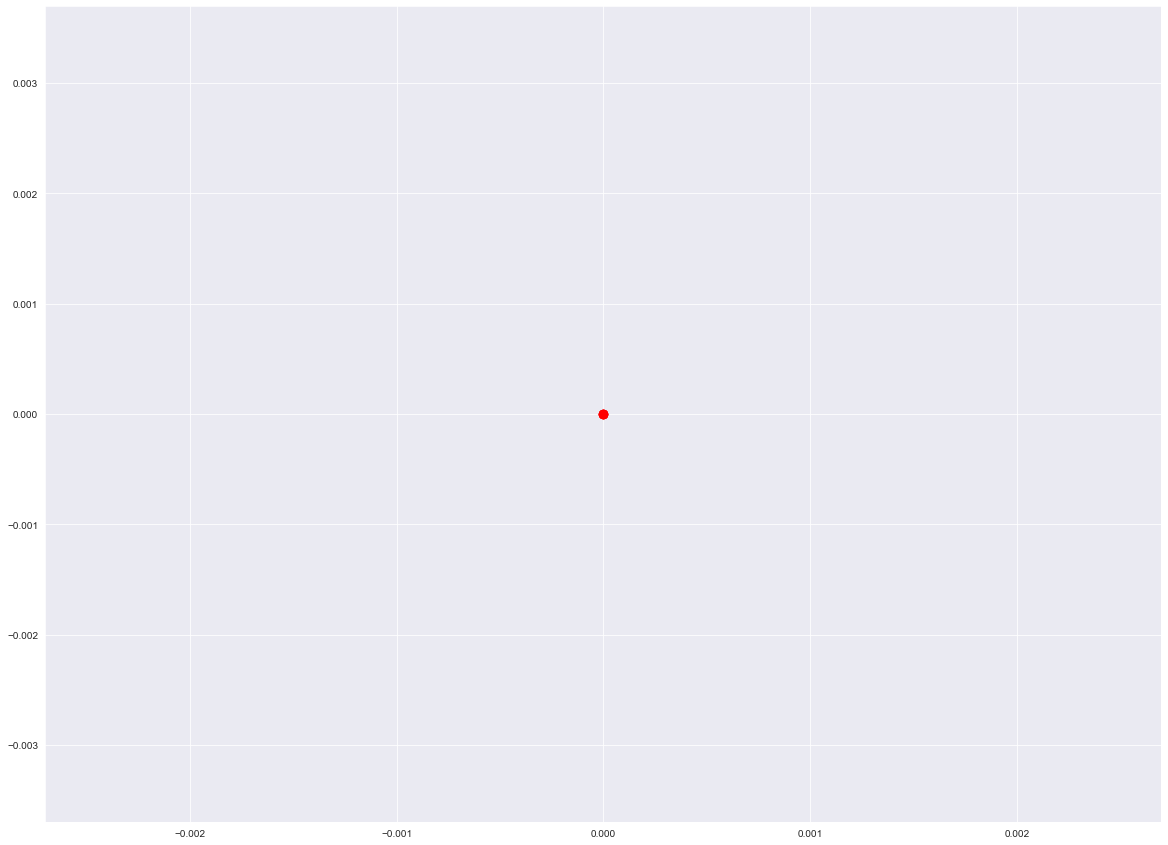

In [247]:
# scatter plot of clusters and their centroids.
plt.figure(figsize=(20,15))
plt.scatter(main_array[:,0], main_array[:,1], c=predicted_clusters, s=30);
# plt.scatter(playlist_array[:,0], playlist_array[:,1], c='b', s=10);
plt.scatter(centers[:,0], centers[:,1], s=70, c='red');

In [132]:
# use distortion as metric to classify similarities betwen songs within df
distortion = []
for k in range(1, 26):  
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(label_array)
    distortion.append(kmeans.inertia_) # inertia_: sum of squared distances of samples to their closest cluster center

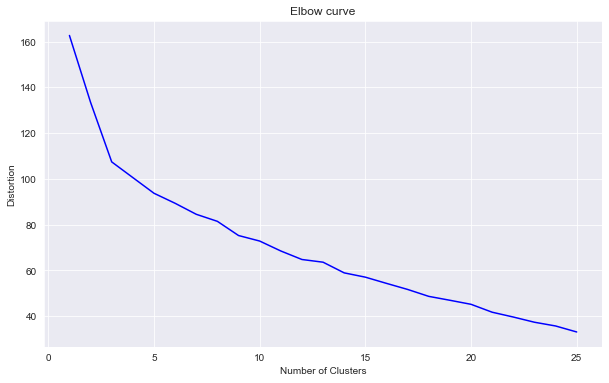

In [133]:
# try elbow plot to find best k for this cluster
fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, 26), distortion, c = 'b')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow curve')
plt.show()